# Imports

In [9]:
## Logging and Shell
import logging
logging.basicConfig(
    level=logging.ERROR,
    force=True
)

## Numeric imports
import pandas as pd

## File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

DIM    = 300
ASPECT = 3/2
IPythonConsole.molSize = (int(ASPECT*DIM), DIM)   # Change image size

# Custom imports
from polymerist.monomers import specification
from polymerist.rdutils.reactions import reactions

# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')

PDB_OUT_DIR   = Path('pdb_files')
PDB_OUT_DIR.mkdir(exist_ok=True)

MONO_INFO_DIR = Path('monomer_fragments')
MONO_INFO_DIR.mkdir(exist_ok=True)

# Load monomer and rxn data 

In [10]:
input_data_path = PROC_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers_FILTERED.csv'
# input_data_path = PROC_DATA_DIR / 'nipu_urethanes_FILTERED.csv'
df = pd.read_csv(input_data_path, index_col=0)

## Load pre-defined functional group SMARTS queries

In [11]:
with Path('poly_rxns/fn_group_smarts.json').open('r') as file:
    fn_group_smarts = json.load(file)

fn_groups = {
    group_name : Chem.MolFromSmarts(smarts)
        for group_name, smarts in fn_group_smarts.items()
}

## Load pre-defined reactions with functional group and name backmap

In [12]:
with (RXN_FILES_DIR / 'rxn_backmap.json').open('r') as file: # load table of functional group for each reaction
    rxn_backmap = json.load(file)

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_backmap.values()
}

In [13]:
blacklisted_rxns = ['imide', 'vinyl']
df = df[df.mechanism.map(lambda s : s not in blacklisted_rxns)]

## Group by mechanism

In [14]:
keys = ['mechanism']

df_grouper = df.groupby(keys)
frames = {
    mech : df_grouper.get_group(mech)
        for mech in df_grouper.groups
}

# Polymerizing fragments

## Example for polymerization of individual molecule

polyurethane_isocyanate


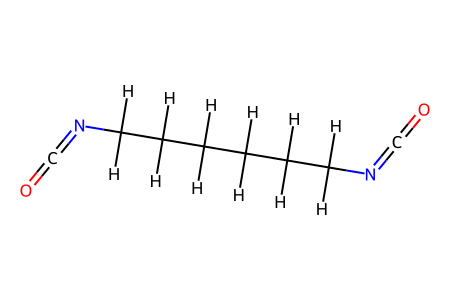

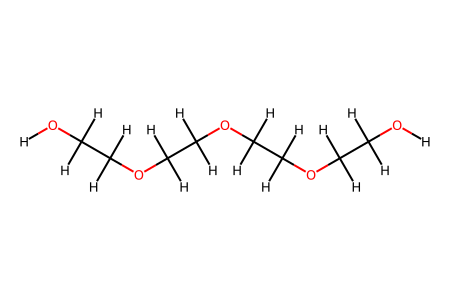

In [15]:
# mechname = 'ester'
# mechname = 'amide'
# mechname = 'carbonate'
mechname = 'urethane'
# mechname = 'vinyl'
# mechname = 'imide'

frame = frames[mechname]
row = frame.loc[frame.index[0]]

mechname = rxn_backmap[row['mechanism']]
print(mechname)

rxn_pathway = rxns[mechname]
named_reactants = {}
for i in range(2):
    reactant = Chem.MolFromSmiles(row[f'smiles_monomer_{i}'], sanitize=False)
    Chem.SanitizeMol(reactant, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    display(reactant)
    named_reactants[ row[f'IUPAC_name_monomer_{i}'] ] = reactant

reactants = [i for i in named_reactants.values()]

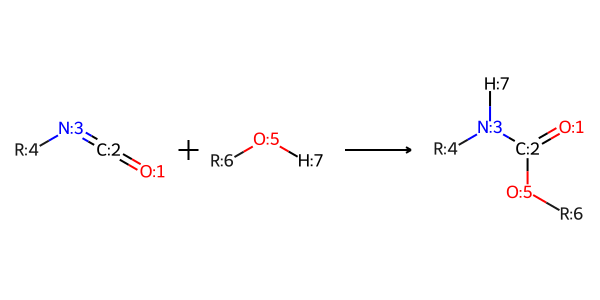

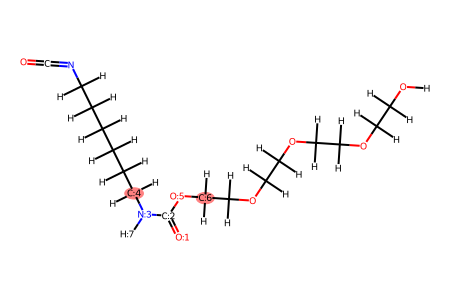

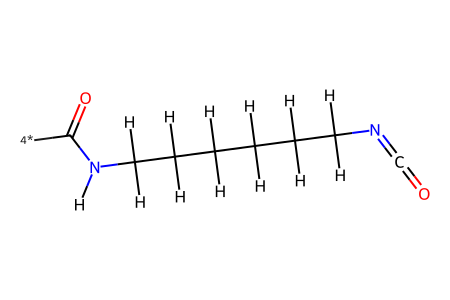

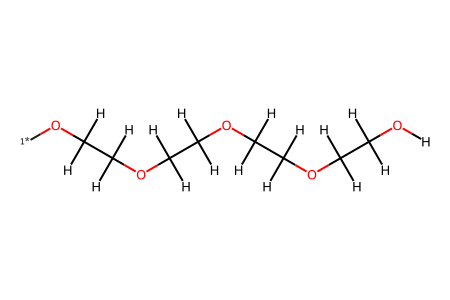

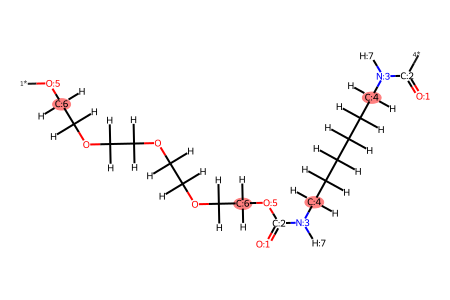

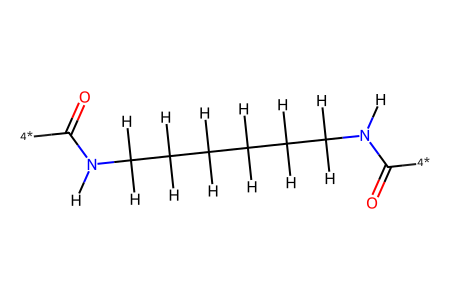

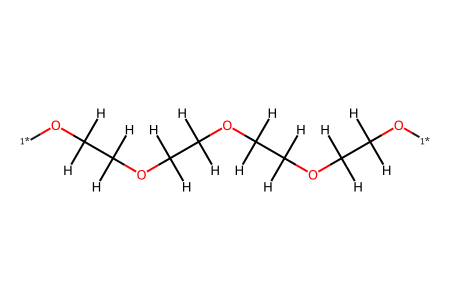

In [16]:
from polymerist.rdutils.amalgamation import portlib
from polymerist.rdutils.reactions import reactors

display(rxn_pathway)
reactor = reactors.PolymerizationReactor(rxn_pathway)
for (dimer, pair) in reactor.propagate(reactants):
    display(dimer)
    for frag in pair:
        display(frag)

    print('='*50)

## Polymerize all SMILES into well-specified fragments with ports

In [17]:
from polymerist.monomers import MonomerGroup
from polymerist.monomers import specification
from polymerist.genutils.containers import RecursiveDict


frag_registry = RecursiveDict()
for (i, row) in df.iterrows():
    # look up reactive groups and pathway by chemistry
    mechname = rxn_backmap[row['mechanism']]
    rxn_pathway = rxns[mechname]

    chem_dir : Path = MONO_INFO_DIR / mechname
    chem_dir.mkdir(exist_ok=True)

    # load reactants with IUPAC names from chemical table
    named_reactants = {}
    for j in range(2):
        reactant = Chem.MolFromSmiles(row[f'smiles_monomer_{j}'], sanitize=False)
        Chem.SanitizeMol(reactant, sanitizeOps=specification.SANITIZE_AS_KEKULE)
        named_reactants[ row[f'IUPAC_name_monomer_{j}'] ] = reactant

    # polymer_name = f'poly({",".join(named_reactants.keys())})' # TODO : make sure this conforms to IUPAC standards for naming
    polymer_name = f'poly({"-co-".join(named_reactants.keys())})' # TODO : make sure this conforms to IUPAC standards for naming
    initial_reactants = [reactants for reactants in named_reactants.values()] # must convert to list
    frag_registry[mechname][i] = polymer_name

    # first round of polymerization (initiation)
    monogrp = MonomerGroup()
    reactor = reactors.PolymerizationReactor(rxn_pathway)
    for dimer, frags in reactor.propagate(initial_reactants):
        for assoc_group_name, rdfragment in zip(named_reactants.keys(), frags):
            # generate spec-compliant SMARTS
            raw_smiles = Chem.MolToSmiles(rdfragment)
            exp_smiles = specification.expanded_SMILES(raw_smiles)
            spec_smarts = specification.compliant_mol_SMARTS(exp_smiles)

            # record to monomer group
            affix = 'TERM' if MonomerGroup.is_terminal(rdfragment) else 'MID'
            monogrp.monomers[f'{assoc_group_name}_{affix}'] = [spec_smarts]

    monogrp.to_file(chem_dir / f'{polymer_name}.json')

with (MONO_INFO_DIR / 'dataset_backmap.json').open('w') as file:
    json.dump(frag_registry, file, indent=4)

# Building PDB files from monomer fragments

In [18]:
from polymerist.maths.greek import GREEK_PREFIXES
from polymerist.polymers import building


DOP = 3

PDB_OUT_DIR.mkdir(exist_ok=True)
pdb_dir = PDB_OUT_DIR / f'{GREEK_PREFIXES[DOP]}mers'
pdb_dir.mkdir(exist_ok=True)

failed = RecursiveDict()
for chemistry in rxn_groups.keys():
    mono_src_dir = MONO_INFO_DIR / chemistry
    if not mono_src_dir.exists():
        continue

    chem_dir = pdb_dir / chemistry
    chem_dir.mkdir(exist_ok=True)

    for mono_path in mono_src_dir.iterdir():
        monogrp = MonomerGroup.from_file(mono_path)
        try:
            polymer = building.build_linear_polymer(monomers=monogrp, DOP=DOP, sequence='AB')  
            savepath = chem_dir / f'{mono_path.stem}.pdb'
            building.mbmol_to_openmm_pdb(savepath, polymer)
            
            # polymer.save(asstrpath(savepath))
        except Exception as e:
            failed[DOP][chemistry][e.__class__.__name__][mono_path.stem] = monogrp

[15:58:21] Explicit valence for atom # 19 N, 4, is greater than permitted


In [19]:
failed

RecursiveDict(polymerist.genutils.containers.RecursiveDict,
              {3: RecursiveDict(polymerist.genutils.containers.RecursiveDict,
                             {'polyurethane_isocyanate': RecursiveDict(polymerist.genutils.containers.RecursiveDict,
                                            {'AtomValenceException': RecursiveDict(polymerist.genutils.containers.RecursiveDict,
                                                           {'poly(1-isocyanato-4-[(4-isocyanatophenyl)methyl]benzene-co-2-[2-hydroxyethyl-[4-(4-nitrophenyl)diazenylphenyl]amino]ethanol)': MonomerGroup(monomers={'1-isocyanato-4-[(4-isocyanatophenyl)methyl]benzene_TERM': ['[4*:1]-[#6D3+0:2](=[#8D1+0:3])-[#7D3+0:4](-[#6D3+0:5]1=[#6D3+0:6](-[#1D1+0:22])-[#6D3+0:7](-[#1D1+0:23])=[#6D3+0:8](-[#6D4+0:9](-[#6D3+0:10]2=[#6D3+0:11](-[#1D1+0:26])-[#6D3+0:12](-[#1D1+0:27])=[#6D3+0:13](-[#7D2+0:14]=[#6D2+0:15]=[#8D1+0:16])-[#6D3+0:17](-[#1D1+0:28])=[#6D3+0:18]-2-[#1D1+0:29])(-[#1D1+0:24])-[#1D1+0:25])-[#6D3+0:19](-[#1D1+0